# Psychometric Analysis - Binary Classification Model

In [160]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [161]:
df = pd.read_csv("merged_psychometric.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   employee_name  3000 non-null   object
 1   user_id        3000 non-null   object
 2   O              3000 non-null   int64 
 3   C              3000 non-null   int64 
 4   E              3000 non-null   int64 
 5   A              3000 non-null   int64 
 6   N              3000 non-null   int64 
 7   Malicious      3000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 187.6+ KB


In [162]:
df['Malicious'].value_counts()

Malicious
0    2831
1     169
Name: count, dtype: int64

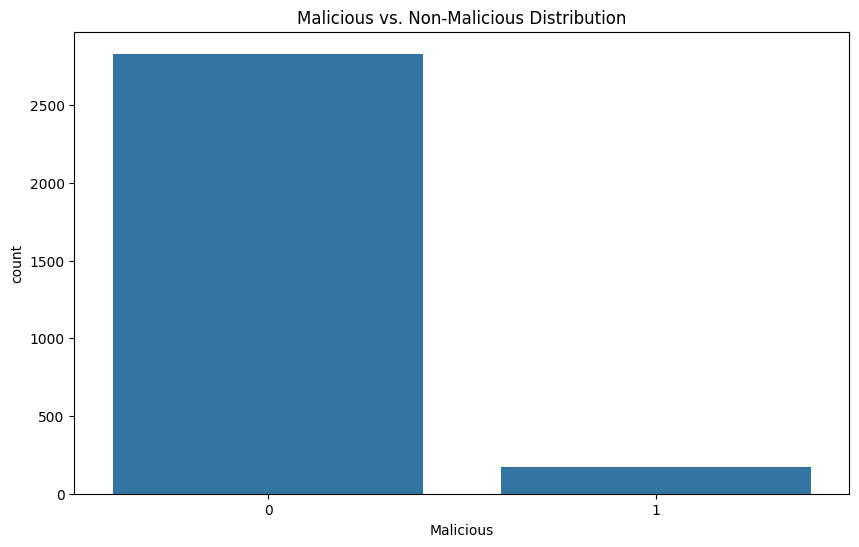

In [163]:
# Visualizations
plt.figure(figsize=(10, 6))
sns.countplot(x='Malicious', data=df)
plt.title("Malicious vs. Non-Malicious Distribution")
plt.show()

<Figure size 1200x800 with 0 Axes>

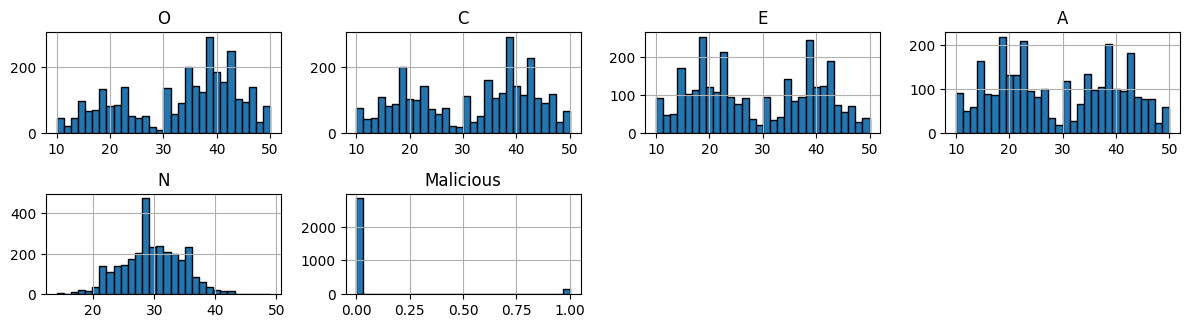

In [164]:
# Visualizing the distribution of numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
plt.figure(figsize=(12, 8))
df[numerical_features].hist(bins=30, figsize=(12, 8), layout=(5, 4), edgecolor='black')
plt.tight_layout()
plt.show()

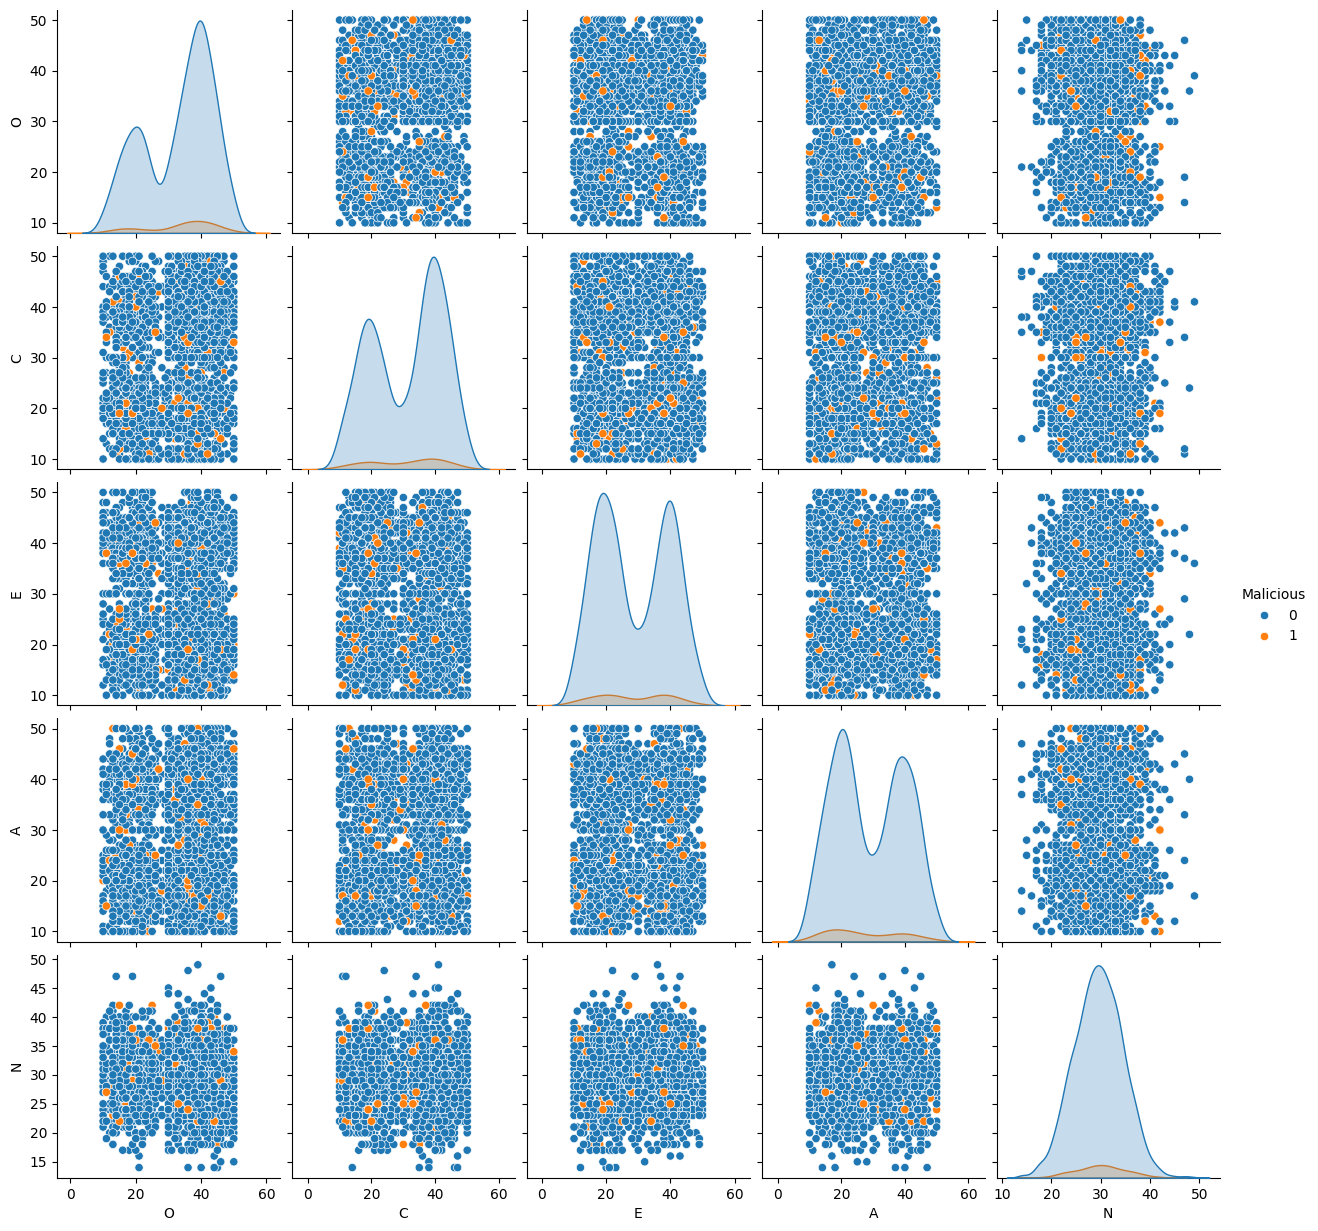

In [165]:
sns.pairplot(df.drop(columns=['user_id']), hue='Malicious')
plt.show()

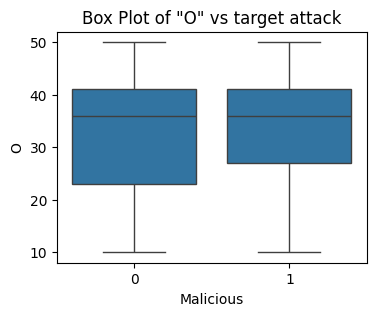

In [166]:
# Box plot
plt.figure(figsize=(4, 3))
sns.boxplot(x=df["Malicious"], y=df["O"])
plt.title(f'Box Plot of "O" vs target attack')
plt.show()

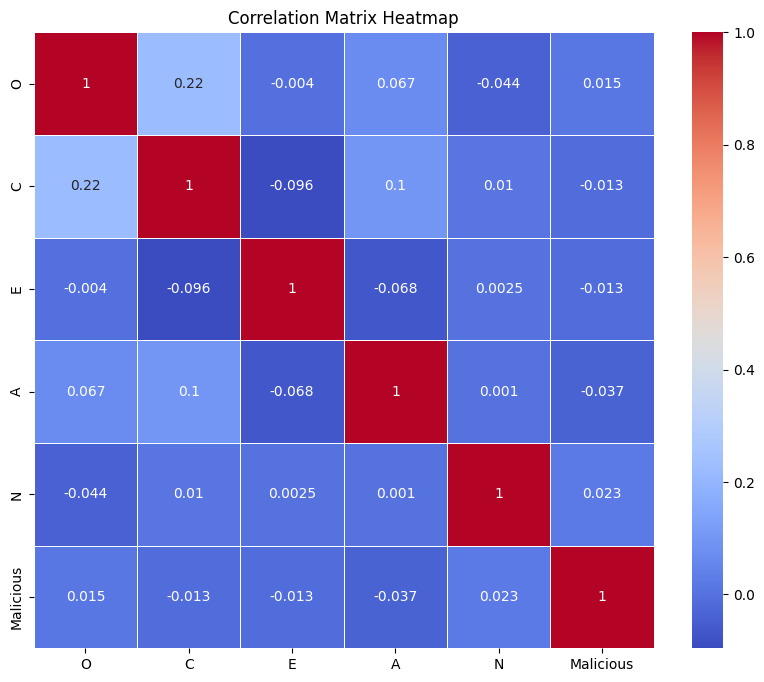

In [167]:
cleaned_df = df.drop(columns=["employee_name", "user_id"])
correlation_with_target = cleaned_df.corr()#['Malicious'].abs()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_with_target, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [168]:
# Oversampling

# df_majority = df[df.Malicious == 0]
# df_minority = df[df.Malicious == 1]
# df_minority_upsampled = resample(df_minority, 
#                                     replace=True, 
#                                     n_samples=len(df_majority), 
#                                     random_state=42)
# df_balanced = pd.concat([df_majority, df_minority_upsampled])

In [169]:
# df_balanced['Malicious'].value_counts()

In [170]:
# X = df_balanced.drop(columns=['user_id', 'employee_name', 'Malicious'])
# y = df_balanced['Malicious']

X = df.drop(columns=['user_id', 'employee_name', 'Malicious'])
y = df['Malicious']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [171]:
y_train.value_counts()

Malicious
0    2269
1     131
Name: count, dtype: int64

In [182]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.3, random_state=42)  # Adjust to 30% of majority class
# smote = SMOTE(random_state=42)  # Adjust to 30% of majority class
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [183]:
# # Undersampling
# rus = RandomUnderSampler()
# X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)

In [184]:
# from imblearn.combine import SMOTEENN

# smote_enn = SMOTEENN(sampling_strategy=0.3)  # Adjust as needed
# X_train_balanced, y_train_balanced = smote_enn.fit_resample(X_train, y_train)

In [185]:
y_train_balanced.value_counts()

Malicious
0    2269
1     680
Name: count, dtype: int64

In [186]:
from xgboost import XGBClassifier


models = {
    # "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=100, random_state=42),#, class_weight="balanced")
    "xgb": XGBClassifier(scale_pos_weight=len(y_train) / sum(y_train == 1))

}

for name, model in models.items():
    print(f"Training {name}...")
    # model.fit(X_train, y_train)
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)

    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred_adjusted = (y_probs > 0.3).astype(int)

    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred))
    print(f"\n{name} Confusion Matrix:\n", confusion_matrix(y_test, y_pred), "\n")
    # print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred_adjusted))
    # print(f"\n{name} Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))

Training Random Forest...

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       562
           1       0.00      0.00      0.00        38

    accuracy                           0.94       600
   macro avg       0.47      0.50      0.48       600
weighted avg       0.88      0.94      0.91       600


Random Forest Confusion Matrix:
 [[562   0]
 [ 38   0]] 

Training xgb...

xgb Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93       562
           1       0.05      0.05      0.05        38

    accuracy                           0.88       600
   macro avg       0.49      0.49      0.49       600
weighted avg       0.88      0.88      0.88       600


xgb Confusion Matrix:
 [[524  38]
 [ 36   2]] 



c:\Users\kgrna\Desktop\CyberSec\Project\psycho_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kgrna\Desktop\CyberSec\Project\psycho_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kgrna\Desktop\CyberSec\Project\psycho_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m


 DT Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       562
           1       0.21      0.13      0.16        38

    accuracy                           0.91       600
   macro avg       0.58      0.55      0.56       600
weighted avg       0.90      0.91      0.90       600


 DT Confusion Matrix:
 [[543  19]
 [ 33   5]]
|--- feature_3 <= -0.63
|   |--- feature_3 <= -0.72
|   |   |--- feature_0 <= -0.95
|   |   |   |--- feature_2 <= 0.64
|   |   |   |   |--- feature_4 <= 0.09
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_4 >  0.09
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_2 >  0.64
|   |   |   |   |--- feature_0 <= -1.93
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_0 >  -1.93
|   |   |   |   |   |--- class: 0
|   |   |--- feature_0 >  -0.95
|   |   |   |--- feature_4 <= -0.51
|   |   |   |   |--- feature_0 <= 0.54
|   |   |   |   |   |--- class: 0
|   |   

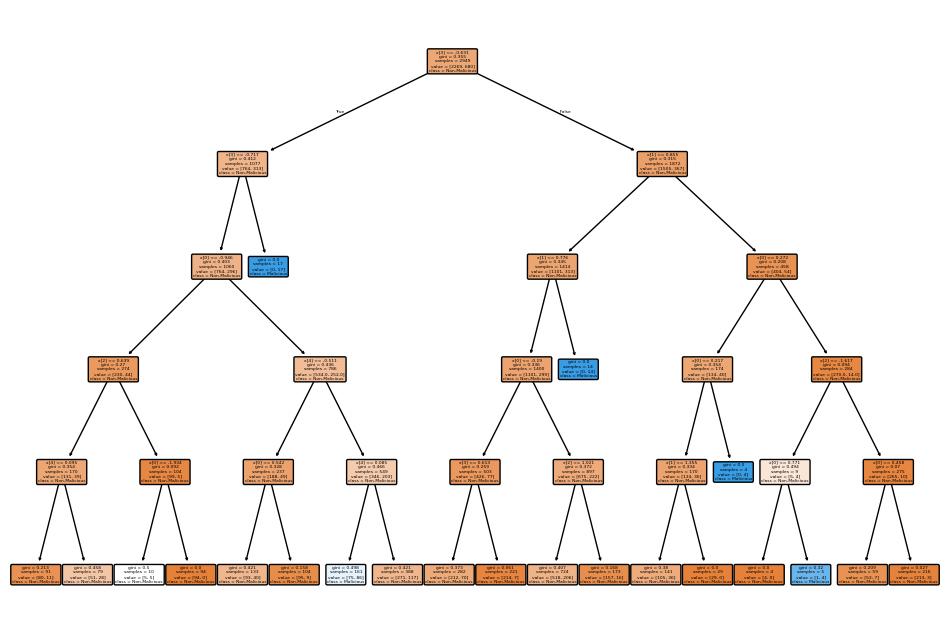

In [187]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import matplotlib.pyplot as plt

# Create Decision Tree model
dt = DecisionTreeClassifier(max_depth=5, random_state=42)  # Limit depth to keep it interpretable
dt.fit(X_train_balanced, y_train_balanced)  # Train the model


y_pred = dt.predict(X_test)

# y_probs = dt.predict_proba(X_test)[:, 1]
# y_pred_adjusted = (y_probs > 0.3).astype(int)

print(f"\n DT Classification Report:\n", classification_report(y_test, y_pred))
print(f"\n DT Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred_adjusted))
# print(f"\n{name} Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))


# Print tree structure in text format
tree_rules = export_text(dt)#, feature_names=list(X_train.columns))
print(tree_rules)

# Visualize the decision tree
plt.figure(figsize=(12, 8))
# plot_tree(dt, feature_names=list(X_train.columns), filled=True, rounded=True, class_names=["Non-Malicious", "Malicious"])
plot_tree(dt, filled=True, rounded=True, class_names=["Non-Malicious", "Malicious"])

plt.show()